<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/Simple_example_on_using_Instrumental_Variables_method_for_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dowhy

     |████████████████████████████████| 123 kB 40.9 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import patsy as ps

from statsmodels.sandbox.regression.gmm import IV2SLS
import os, sys
from dowhy import CausalModel

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## We create a fictitious dataset with the goal of estimating the impact of education on future earnings of an individual. The ability of the individual is a confounder and being given an education_voucher is the instrument.

In [4]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

# build dataset (exclude confounder `ability` which we assume to be unobserved)
data = np.stack([education, income, voucher]).T
df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

## Note that the real effect of education (treatment) on income is 4

Note that ability, a factor which influences both income and education, is unobserved !!!

In [5]:
df

,education,income,voucher
0,3.255789,25.283927,-0.064325
1,-0.386182,-3.496941,0.612688
2,6.617194,35.616558,0.255174
3,7.219453,29.662962,1.897590
4,11.223111,59.088658,2.355276
...,...,...,...
995,10.358359,53.692831,1.626094
996,9.837301,52.364995,2.857632
997,8.946566,50.955394,1.298716
998,4.873658,24.843591,1.059733


# Step 1. Model the problem

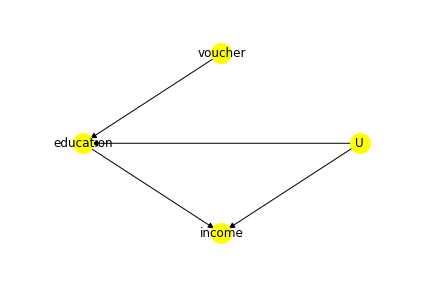

In [7]:
#Step 1: Model
model=CausalModel(
        data = df,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Step 2. Identify

In [8]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                           
────────────(Expectation(income))
d[education]                     
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,,U) = P(income|education,)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**
(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



# Step 3. Estimate

In [9]:
# Step 3: Estimate
#Choose the second estimand: using IV
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**
(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(income, voucher))⋅Expectation(Derivative(education, vou

      -1
cher))  
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['education'] is affected in the same way by common causes of ['educatio

## We have an estimate, indicating that increasing education by one unit increases income by 4 points.

# Step 4. Refute

In [11]:
# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute") # only permute placebo_type works with IV estimate
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:3.967100097638284
New effect:0.04834316079207432
p value:0.39

